<a href="https://colab.research.google.com/github/Amaljayaranga/ContrastiveLoss/blob/master/Hard_Sampling_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


training started
Epoch 1 Stage train loss  0.049532219646296435
Epoch 1 Stage eval loss  0.05108653535746565
Epoch 2 Stage train loss  0.04496407710973528
Epoch 2 Stage eval loss  0.04706483093476055
Epoch 3 Stage train loss  0.043265315882849174
Epoch 3 Stage eval loss  0.04275024448982393
Epoch 4 Stage train loss  0.04173696214622369
Epoch 4 Stage eval loss  0.04196849696789727
Epoch 5 Stage train loss  0.04166855080945663
Epoch 5 Stage eval loss  0.04166418029879681
Epoch 6 Stage train loss  0.041302365006782575
Epoch 6 Stage eval loss  0.04101212794958341
Epoch 7 Stage train loss  0.04043280508972468
Epoch 7 Stage eval loss  0.03926033043123857
Epoch 8 Stage train loss  0.03994591076405896
Epoch 8 Stage eval loss  0.042526863063826706
Epoch 9 Stage train loss  0.03977128315113721
Epoch 9 Stage eval loss  0.040193267825125445
Epoch 10 Stage train loss  0.0397986637518581
Epoch 10 Stage eval loss  0.04056166373945848
Epoch 11 Stage train loss  0.03922960182064165
Epoch 11 Stage eval 

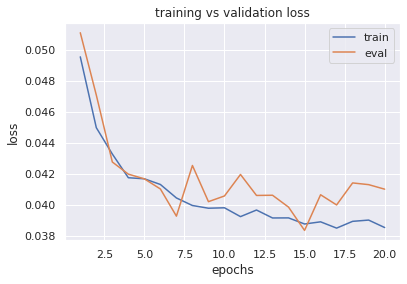

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
from itertools import combinations
import torch.nn as nn
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import BatchSampler
from scipy.spatial import distance_matrix
import math
import torch.nn.functional as F
from argparse import ArgumentParser
import seaborn as sns;sns.set()

parser = ArgumentParser(description='Simase Network')
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=0.8)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=20)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--no_pairs_from_class', type=int, default=5)

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'


class MNISTBatchSampler(BatchSampler):
    def __init__(self, labels, no_classes, no_samples):
        self.labels = labels
        self.no_classes = no_classes
        self.no_samples = no_samples
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        self.batch_size = self.no_samples*self.no_classes
        self.length_dataset = len(self.labels)

        #shuffling
        for label in self.labels_set:
            np.random.shuffle(self.label_to_indices[label])

        self.used_label_indices_count = {label : 0 for label in self.labels_set}

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.length_dataset:
            classes = np.random.choice(self.labels_set, self.no_classes, replace=False)
            indices = []
            for class_i in classes:
                start = self.used_label_indices_count[class_i]
                end = start+self.no_samples
                indices.extend(self.label_to_indices[class_i][start:end])
                self.used_label_indices_count[class_i] += self.no_samples

                if self.used_label_indices_count[class_i] + self.no_samples > len(self.label_to_indices[class_i]):
                    np.random.shuffle(self.label_to_indices[class_i])
                    self.used_label_indices_count[class_i] = 0
            yield indices
            self.count += self.no_classes*self.no_samples

    def __len__(self):
        return self.length_dataset//self.batch_size


class PairSelector:
    def __init__(self, no_positive_pairs_each_class):
        self.n_psc = no_positive_pairs_each_class

    def get_pairs(self,images_t, labels):
        self.images_t = images_t
        self.labels = labels
        self.labels_set = list(set(labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0] for label in self.labels_set}

        pair_1 = torch.Tensor()
        pair_2 = torch.Tensor()
        target = torch.Tensor()

         #mining positive pairs
        for label in self.labels_set:
            imgs_label = self.label_to_indices.get(label)
            list_label = []
            for i1 in imgs_label:
                list_label.append(self.images_t[i1].view(-1, 28 * 28).double().numpy()[0])

            dis_mat = distance_matrix(list_label, list_label)
            dis_mat_upper_tri = np.triu(dis_mat)

            indices = (-dis_mat_upper_tri).argpartition(self.n_psc, axis=None)[:self.n_psc]
            index_x, index_y = np.unravel_index(indices, dis_mat_upper_tri.shape)

            ones_t = torch.ones(len(index_x))
            target = torch.cat((target,ones_t))

            for i, j in zip(index_x, index_y):
                pair_1 = torch.cat((pair_1, self.images_t[imgs_label[i]]))
                pair_2 = torch.cat((pair_2, self.images_t[imgs_label[j]]))

        #mining negative samples
        label_imgs_dict = {}
        for label in self.labels_set:
            label_imgs = []
            for img_index in self.label_to_indices.get(label):
                label_imgs.append(self.images_t[img_index].view(-1, 28 * 28).double().numpy()[0])
            label_imgs_dict[label] = label_imgs

        all_pairs = np.array(list(combinations(range(len(self.labels_set)), 2)))
        len_matrix = len(label_imgs_dict.get(all_pairs[0][0])) ** 2
        all_distance_matrixes = {}

        for pair in all_pairs:
            pair_t = tuple(pair)
            for label_t in pair_t:
                dis_mat = distance_matrix(label_imgs_dict.get(label_t), label_imgs_dict.get(label_t))
                dis_mat_upper_tri = np.triu(dis_mat)
                all_distance_matrixes[pair_t] = dis_mat_upper_tri

        #adding all distance matrixes into one array
        all_distance_matrixes_arr = np.array([])
        for dis_mat in all_distance_matrixes.values():
             all_distance_matrixes_arr = np.append(all_distance_matrixes_arr,dis_mat)

        no_top_negative_pairs = self.n_psc * len(self.labels_set)
        zero_indices = np.nonzero(all_distance_matrixes_arr)[0]
        negative_indices_arr = zero_indices[np.argsort(all_distance_matrixes_arr[zero_indices])][:no_top_negative_pairs]

        zeors_t = torch.zeros(len(negative_indices_arr))
        target = torch.cat((target, zeors_t))

        for idx in negative_indices_arr:
            tuple_index = math.floor(idx/len_matrix)
            image_pair_index = idx % len_matrix
            keys = all_distance_matrixes.keys()
            label_pair = list(keys)[tuple_index]
            img_x = math.floor(image_pair_index / math.sqrt(len_matrix))
            img_y = (image_pair_index % math.sqrt(len_matrix)).astype(np.int64)
            n1 = torch.Tensor(label_imgs_dict.get(label_pair[0])[img_x]).view(-1, 28).unsqueeze(dim=0)
            n2 = torch.Tensor(label_imgs_dict.get(label_pair[1])[img_y]).view(-1, 28).unsqueeze(dim=0)
            pair_1 = torch.cat((pair_1, n1))
            pair_2 = torch.cat((pair_2, n2))

        pairs = pair_1.unsqueeze(dim=1), pair_2.unsqueeze(dim=1), target
        return pairs


class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output,target):
        eq_distance = F.pairwise_distance(output[0], output[1])
        loss = 0.5 * (1 - target) * torch.pow(eq_distance, 2) + \
               0.5 * target * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)

        return loss.mean()

class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet,self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.Conv2d(in_channels=32,out_channels=64, kernel_size=5),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2)
                                  )
        #output 64,4,4
        self.fc = nn. Sequential(nn.Linear(64*4*4,256),
                                 nn.ReLU(),
                                 nn.Linear(256,256),
                                 nn.ReLU(),
                                 nn.Linear(256,16)
                                 )

    def forward(self, in1, in2):
        x = torch.cat((in1,in2),dim=0)
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        out1, out2 = torch.split(x, x.size(0)//2, dim=0 )
        return out1, out2


train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))

train_sampler = MNISTBatchSampler(train_dataset.train_labels, no_classes=10, no_samples=10)
siamese_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)

eval_sampler = MNISTBatchSampler(test_dataset.test_labels, no_classes=10, no_samples=10)
siamese_eval_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=eval_sampler)

dataloaders = []
dataloaders.append(siamese_train_loader)
dataloaders.append(siamese_eval_loader)

model = SiameseNet()
model = model.to(DEVICE)
pair_selector = PairSelector(args.no_pairs_from_class)


def splot_images(img1, img2, no_pairs):
    #for positives
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Positive Pairs', fontsize=16)
    columns = no_pairs*2
    rows = no_pairs*2
    for i in range(1, int((columns * rows)/2)+1):
        fig.add_subplot(rows, columns, (2*i)-1)
        plt.imshow(img1[i-1].squeeze())
        plt.axis('off')
        fig.add_subplot(rows, columns, 2*i)
        plt.imshow(img2[i-1].squeeze())
        plt.axis('off')
    plt.show()

    # for negatives
    fig1 = plt.figure(figsize=(10, 10))
    fig1.suptitle('Negative Pairs', fontsize=16)
    columns = no_pairs * 2
    rows = no_pairs * 2
    for i in range(1, int((columns * rows)/2)+1):
        fig1.add_subplot(rows, columns, (2*i)-1)
        plt.imshow(img1[i+ int((columns * rows)/2)-1].squeeze())
        plt.axis('off')
        fig1.add_subplot(rows, columns, 2*i)
        plt.imshow(img2[i+int((columns * rows)/2)-1].squeeze())
        plt.axis('off')
    plt.show()


def draw_loss_plot(training_losses,validation_losses,epochs):
    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training vs validation loss')
    plt.legend()
    plt.show()

if args.mode == 'train':

    criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    print('training started')

    training_losses = []
    validation_losses = []
    epochs = []

    for epoch in range(1, args.num_epochs + 1):
        epochs.append(epoch)

        epoch_loss = []
        chunk = 100

        for dataloader in dataloaders:

            if dataloader == siamese_train_loader:
                model.train()
            else:
                model.eval()

            epoch_losses = []

            for batch_idx, batch in enumerate(dataloader):

                images, labels = batch[0], batch[1]

                img1, img2, target = pair_selector.get_pairs(images, labels)
                #splot_images(img1, img2, args.no_pairs_from_class)

                img1 = img1.to(DEVICE)
                img2 = img2.to(DEVICE)
                target = target.to(DEVICE)

                out1, out2 = model(img1, img2)
                out = [out1, out2]
                loss = criterion(out, target)

                if dataloader == siamese_train_loader:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                epoch_losses.append(loss.item())
                #if batch_idx % chunk == 0:
                    #print("Epoch : ", epoch, "Batch : ", batch_idx, "loss : ", loss.item())


            stage = 'train'
            if dataloader == siamese_train_loader:
                training_losses.append(np.mean(epoch_losses))
            else:
                stage = 'eval'
                validation_losses.append(np.mean(epoch_losses))

            print("Epoch", epoch, "Stage", stage, "loss ", np.mean(epoch_losses))

    draw_loss_plot(training_losses,validation_losses,epochs)
    torch.save(model, 'simase.pth')




















